In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
from collections import Counter
import scipy
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from sklearn import metrics
import gget
import tabulate
import sklearn
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import sys


# locals
sys.path.append('../')
import utils as ut

In [2]:
annPath =  "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/CARDInputs/_global_clusters.csv"
ldf = pd.read_csv(annPath)

tab = ldf[['cellType', 'sampleInfo']].value_counts().reset_index(drop=False)
tab = tab.sort_values(by=['sampleInfo', 'cellType'], ascending=[False, True])
print(tab.to_latex(index=False))

\begin{tabular}{llr}
\toprule
        cellType & sampleInfo &     0 \\
\midrule
         B cells &         ND &   362 \\
 Dendritic cells &         ND &   143 \\
            Mac1 &         ND &   136 \\
            Mac2 &         ND &    25 \\
            Mac3 &         ND &   179 \\
            Mac4 &         ND &    15 \\
            Mac5 &         ND &     4 \\
       Monocytes &         ND &   175 \\
        NK cells &         ND &    96 \\
   Stromal cells &         ND &    33 \\
         T cells &         ND &    93 \\
         B cells &       HFD8 &   282 \\
 Dendritic cells &       HFD8 &  1058 \\
            Mac1 &       HFD8 &   317 \\
            Mac2 &       HFD8 &   406 \\
            Mac3 &       HFD8 &   519 \\
            Mac4 &       HFD8 &   613 \\
            Mac5 &       HFD8 &   333 \\
       Monocytes &       HFD8 &   714 \\
        NK cells &       HFD8 &   505 \\
   Stromal cells &       HFD8 &    78 \\
         T cells &       HFD8 &  1298 \\
         B cells &

In [3]:


macTypes = [
    'Mac1',
    'Mac2',
    'Mac3',
    'Mac4',
    'Mac5',
]

ldf = ldf[ldf['cellType'].isin(macTypes)]
print(f"{ldf.shape=}")
print()
print(ldf['sampleInfo'].value_counts())

ldf.head()

ldf.shape=(6431, 4)

HFD14    3884
HFD8     2188
ND        359
Name: sampleInfo, dtype: int64


,Unnamed: 0,cellId,cellType,sampleInfo
1,1,AAAGAACGTCTACAGT.1_ND,Mac1,ND
2,2,AAAGAACTCCTCGCAT.1_ND,Mac1,ND
3,3,AAAGGGCGTTAGGGTG.1_ND,Mac3,ND
5,5,AACAAAGCACCGGCTA.1_ND,Mac3,ND
6,6,AACAAAGGTTCACGAT.1_ND,Mac1,ND


In [4]:
rnaPath =  "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/CARDInputs/_global_rna.csv"
rdf = pd.read_csv(rnaPath)
rdf = rdf.rename(columns={'Unnamed: 0' : 'gene'})
rdf = rdf.set_index('gene')
rdf = rdf.T
rdf.head()

gene,XKR4,GM1992,GM37381,RP1,SOX17,GM37323,MRPL15,LYPLA1,GM37988,TCEA1,...,AC125149.1,AC125149.2,AC125149.4,AC234645.1,AC168977.2,AC168977.1,AC149090.1,CAAA01118383.1,VMN2R122,CAAA01147332.1
AAACGAACAGCAGTAG.1_ND,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
AAAGAACGTCTACAGT.1_ND,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
AAAGAACTCCTCGCAT.1_ND,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5.0,1.0,0.0,0.0
AAAGGGCGTTAGGGTG.1_ND,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
AACAAAGAGTATAGGT.1_ND,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [5]:
"""subset and normalize """
mdf = rdf[rdf.index.isin(ldf['cellId'])]

# gets genes expressed in at least 10% of the population
t = 0.05
nExp = mdf.astype(bool).sum(axis=0)
print(f"{nExp.shape=}")
nExp = nExp / mdf.shape[0]

genes = nExp[nExp > t]
print(f"{genes.shape=}")

mdf = mdf[genes.index]

mdf = ut.normalize(mdf, 1e6)
print(f"{mdf.shape=}")

nExp.shape=(31053,)
genes.shape=(8728,)
mdf.shape=(6431, 8728)


In [6]:
r = 0.99 # 80% of the explained variance

pca = PCA(n_components=r)
pcaModel = pca.fit(mdf)
Xpca = pca.fit_transform(mdf)

Xpca.shape

(6431, 1817)

In [7]:
metric = 'correlation'

# compute pairwise similarity
# A = metrics.pairwise_distances(Xpca, metric=metric)
A = metrics.pairwise_distances(mdf, metric=metric)
print(A.shape)
A = pd.DataFrame(A, columns=[mdf.index], index=mdf.index)
A.head()

(6431, 6431)


,AAAGAACGTCTACAGT.1_ND,AAAGAACTCCTCGCAT.1_ND,AAAGGGCGTTAGGGTG.1_ND,AACAAAGCACCGGCTA.1_ND,AACAAAGGTTCACGAT.1_ND,AACAACCGTTGACTAC.1_ND,AACAGGGAGCTGAAGC.1_ND,AACCAACTCCGATTAG.1_ND,AACCACAAGGTAATCA.1_ND,AACGGGAGTTATTCCT.1_ND,...,TTTGGTTCATAGGAGC.1_HFD14,TTTGGTTGTGGGACAT.1_HFD14,TTTGGTTTCAACTACG.1_HFD14,TTTGGTTTCACTGTTT.1_HFD14,TTTGTTGAGGTTATAG.1_HFD14,TTTGTTGGTCCACTTC.1_HFD14,TTTGTTGGTTAGGAGC.1_HFD14,TTTGTTGTCACGAACT.1_HFD14,TTTGTTGTCGACCTAA.1_HFD14,TTTGTTGTCTGGGCCA.1_HFD14
AAAGAACGTCTACAGT.1_ND,0.000000,0.248633,0.587603,0.598101,0.404398,0.566845,0.270758,0.541444,0.542347,0.579514,...,0.488858,0.320750,0.279881,0.383655,0.322215,0.356611,0.477158,0.344946,0.627308,0.558057
AAAGAACTCCTCGCAT.1_ND,0.248633,0.000000,0.607754,0.551843,0.370539,0.468177,0.290889,0.590183,0.486984,0.536584,...,0.573414,0.272859,0.269186,0.399391,0.445789,0.490743,0.621492,0.479461,0.710831,0.658339
AAAGGGCGTTAGGGTG.1_ND,0.587603,0.607754,0.000000,0.058796,0.619615,0.084265,0.536357,0.090304,0.097321,0.175327,...,0.415158,0.253466,0.383894,0.588082,0.682709,0.458527,0.519567,0.586130,0.674510,0.540955
AACAAAGCACCGGCTA.1_ND,0.598101,0.551843,0.058796,0.000000,0.626634,0.065298,0.551329,0.132544,0.095516,0.223518,...,0.474837,0.228140,0.384955,0.609375,0.723095,0.516018,0.587874,0.636697,0.732744,0.606043
AACAAAGGTTCACGAT.1_ND,0.404398,0.370539,0.619615,0.626634,0.000000,0.588350,0.409956,0.543460,0.536766,0.545182,...,0.306336,0.451530,0.298221,0.273022,0.313656,0.308047,0.312504,0.319447,0.310036,0.272011


(array([0.5, 1.5, 2.5, 3.5, 4.5]),
 [Text(0, 0.5, 'Mac1'),
  Text(0, 1.5, 'Mac2'),
  Text(0, 2.5, 'Mac3'),
  Text(0, 3.5, 'Mac4'),
  Text(0, 4.5, 'Mac5')])

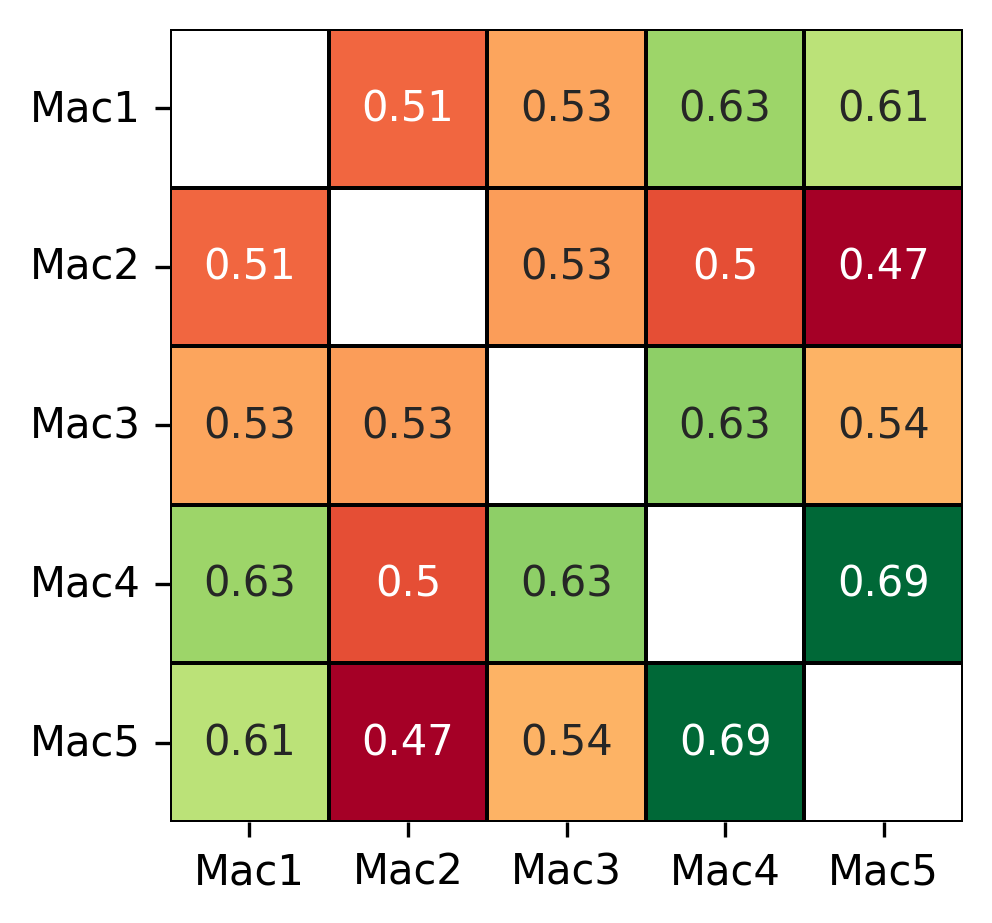

In [11]:

res = np.zeros((5, 5))

for i, i_type in enumerate(macTypes):
    for j, j_type in enumerate(macTypes):
        if not i_type == j_type:
            
            i_idx = ldf[ldf['cellType'] == i_type].cellId.to_list()
            j_idx = ldf[ldf['cellType'] == j_type].cellId.to_list()
            
            meanDist = A[A.index.isin(i_idx)]
            meanDist = meanDist[j_idx]
            
            # meanDist = sklearn.preprocessing.minmax_scale(meanDist, feature_range=(0, 1))
            
            res[i, j] = np.mean(meanDist.mean())
    
np.fill_diagonal(res, np.nan)

res = 1 - res
res = pd.DataFrame(res, columns=macTypes, index=macTypes)


plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.figsize'] = 3.5, 3.5

sns.heatmap(res, 
            cmap='RdYlGn',
            linewidth=0.5,
            cbar=False,
            annot=True,
            linecolor='k',
            square=True)

plt.ylabel("")
plt.xlabel("")

plt.yticks(rotation=0)

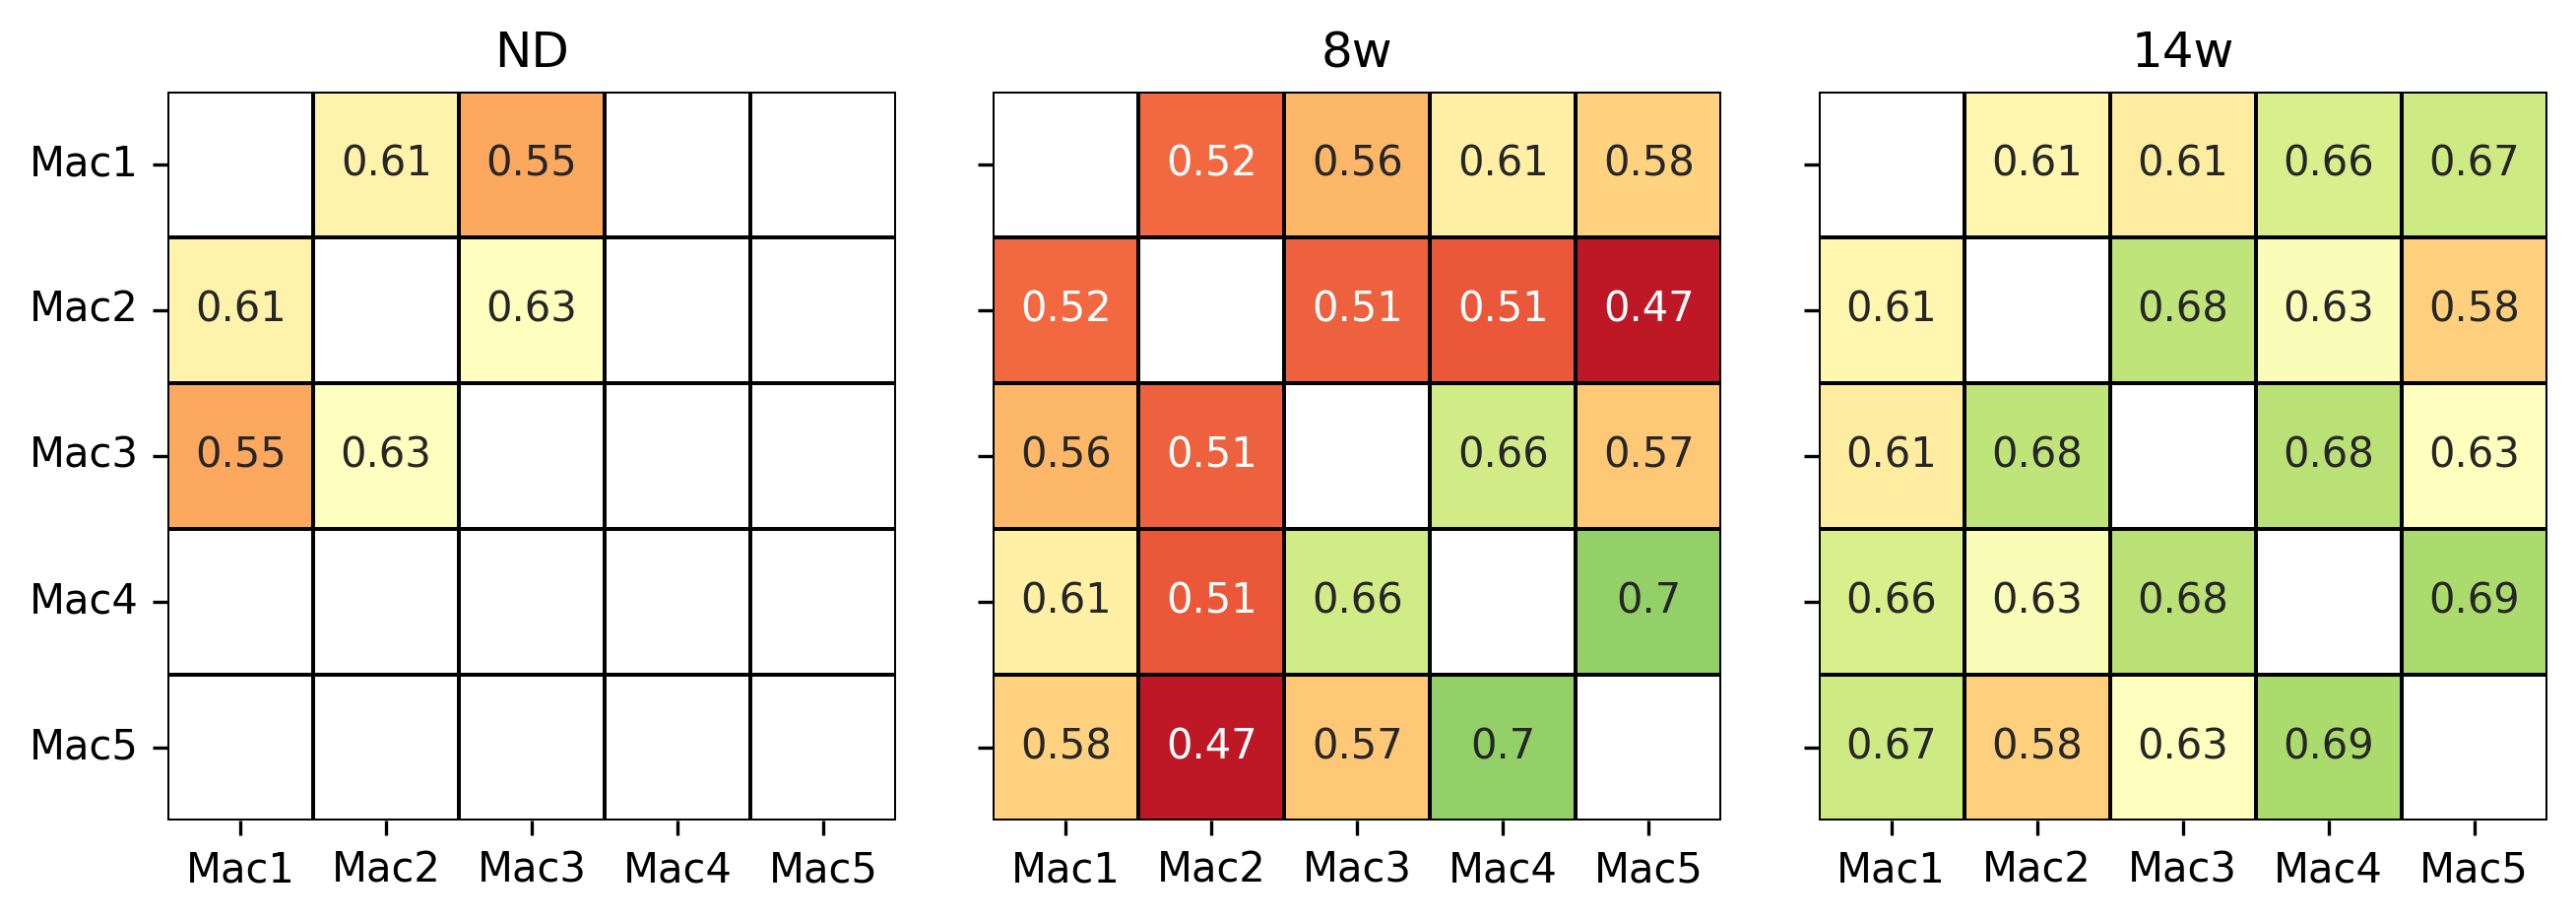

In [34]:
cellThresh = 20
keyCorr = {}

for key in ['ND', 'HFD8', 'HFD14']:
    kdf = ldf[ldf['sampleInfo'] == key]
    res = np.zeros((5, 5))
    for i, i_type in enumerate(macTypes):
        for j, j_type in enumerate(macTypes):
            if not i_type == j_type:

                i_idx = kdf[kdf['cellType'] == i_type].cellId.to_list()
                j_idx = kdf[kdf['cellType'] == j_type].cellId.to_list()
                
                if len(i_idx) < cellThresh or len(j_idx) < cellThresh:
                    res[i, j] = np.nan
                else:
                    meanDist = A[A.index.isin(i_idx)]
                    meanDist = meanDist[j_idx]
                    res[i, j] = np.mean(meanDist.mean())
    
    np.fill_diagonal(res, np.nan)
    res = 1 - res
    res = pd.DataFrame(res, columns=macTypes, index=macTypes)
    keyCorr[key] = res
                

        
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.figsize'] = 9, 3

fig, axs = plt.subplots(1, 3, sharey=True)
axs = axs.ravel()


sns.heatmap(keyCorr['ND'], 
            cmap='RdYlGn',
            linewidth=0.5,
            cbar=False,
            annot=True,
            vmin=0.45, 
            vmax=0.8,
            linecolor='k',
            square=True,
            ax=axs[0]
            )

axs[0].set_title("ND")
axs[0].set_ylabel("")
axs[0].set_xlabel("")
axs[0].tick_params(rotation=0)

sns.heatmap(keyCorr['HFD8'], 
            cmap='RdYlGn',
            linewidth=0.5,
            cbar=False,
            annot=True,
            vmin=0.45, 
            vmax=0.8,
            linecolor='k',
            square=True,
            ax=axs[1]
            )

axs[1].set_title("8w")
axs[1].set_ylabel("")
axs[1].set_xlabel("")
axs[1].tick_params(rotation=0)

sns.heatmap(keyCorr['HFD14'], 
            cmap='RdYlGn',
            linewidth=0.5,
            cbar=False,
            annot=True,
            vmin=0.45, 
            vmax=0.8,
            linecolor='k',
            square=True,
            ax=axs[2]
            )

axs[2].set_title("14w")
axs[2].set_ylabel("")
axs[2].set_xlabel("")
axs[2].tick_params(rotation=0)

plt.tight_layout()